In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

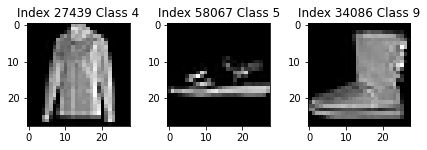

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

56373
23924
17048
55289
32399
55985
41239
9449
23706


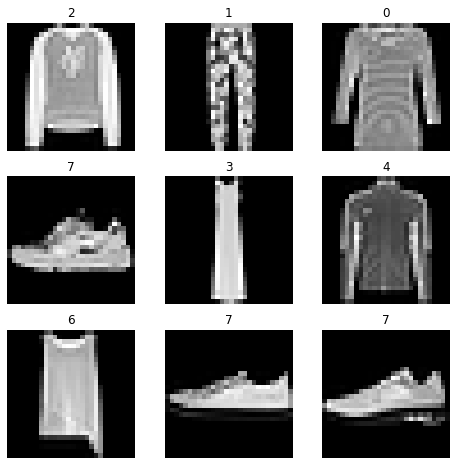

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = int(np.random.randint(X_train.shape[0],size=1))
    print(sample_idx)
    img = X_train[sample_idx].reshape(28,28)
    label = y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [6]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [7]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [9]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    
     # Initialize weights between 1st hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)

        
    grads = tape.gradient(current_loss, self.variables)

    return grads
    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    h1 = tf.matmul(X_tf, self.W1) + self.b1
    z1 = tf.nn.relu(h1)
    
    h2 = tf.matmul(z1, self.W2) + self.b2
    z2 = tf.nn.relu(h2)
    

    # Compute output
    output = tf.matmul(z2, self.W3) + self.b3
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


Train Accuracy: 0.7950
Number of Epoch = 1 - Average Cross Entropy:= 0.008140585327148437 

Validation Accuracy: 0.7881

Train Accuracy: 0.8272
Number of Epoch = 2 - Average Cross Entropy:= 0.004342020568847656 

Validation Accuracy: 0.8187

Train Accuracy: 0.8412
Number of Epoch = 3 - Average Cross Entropy:= 0.003766419982910156 

Validation Accuracy: 0.8326

Train Accuracy: 0.8496
Number of Epoch = 4 - Average Cross Entropy:= 0.00347933349609375 

Validation Accuracy: 0.8425

Train Accuracy: 0.8559
Number of Epoch = 5 - Average Cross Entropy:= 0.003289736328125 

Validation Accuracy: 0.8483

Train Accuracy: 0.8600
Number of Epoch = 6 - Average Cross Entropy:= 0.0031496249389648436 

Validation Accuracy: 0.8516

Train Accuracy: 0.8633
Number of Epoch = 7 - Average Cross Entropy:= 0.0030390628051757814 

Validation Accuracy: 0.8534

Train Accuracy: 0.8672
Number of Epoch = 8 - Average Cross Entropy:= 0.0029447946166992187 

Validation Accuracy: 0.8560

Train Accuracy: 0.8707
Number of

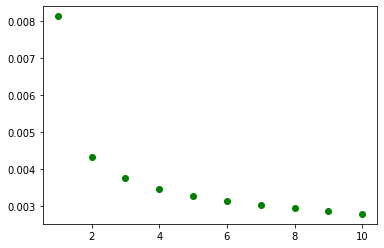

In [10]:
# Set number of epochs
NUM_EPOCHS = 10
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    grads = mlp_on_cpu.backward(inputs, outputs)
    optimizer.apply_gradients(zip(grads,  mlp_on_cpu.variables))


  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

In [11]:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

from typing import List, Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    true: np.ndarray,
    pred: np.ndarray,
    labels: Optional[List[str]] = None,
    normalize: str = "true",
    figsize: Sequence[int] = (5, 4),
) -> np.ndarray:
    """Plot confusion matrix
    Args:
        true (numpy.array): true label
        pred (numpy.array): predicted label
        labels (List[str]), default=None] list of label names
        normalize (str, default="true): whether to normalize scores, chosen from "true" or "false"
    Returns:
        fig: figure of confusion matrix
    """
    cm = confusion_matrix(true, pred, normalize=normalize)
    fig = plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        square=True,
        vmin=0,
        vmax=1.0,
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Normalized confusion matrix")

    plt.close()
    return fig

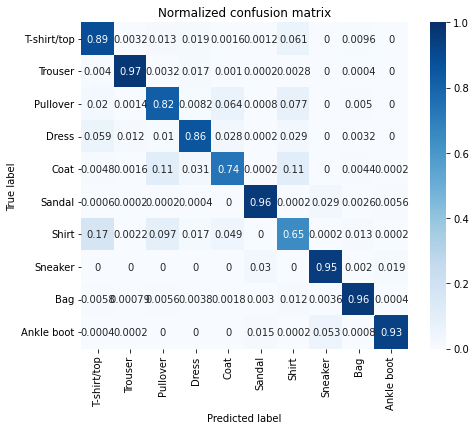

In [12]:
preds = mlp_on_cpu.forward(X_train)
preds = tf.nn.softmax(preds)
final_preds = tf.argmax(preds, 1)
plot_confusion_matrix(y_train.argmax(axis=1), final_preds, labels=class_names, figsize=(8, 6))

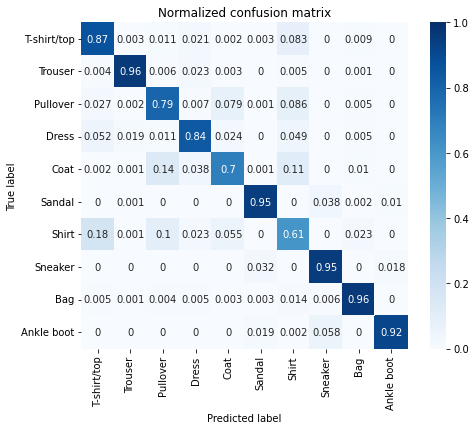

In [13]:
preds = mlp_on_cpu.forward(X_test)
preds = tf.nn.softmax(preds)
final_preds = tf.argmax(preds, 1)
plot_confusion_matrix(y_test.argmax(axis=1), final_preds, labels=class_names, figsize=(8, 6))

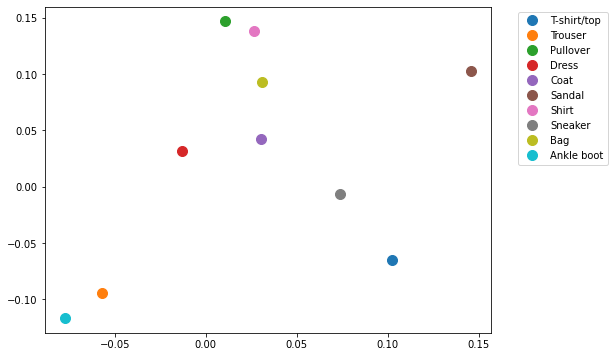

In [14]:
W3_train = mlp_on_cpu.W3.numpy()
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(W3_train[0, cls], W3_train[1, cls], '.', markersize=20, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [15]:
from sklearn.manifold import TSNE


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


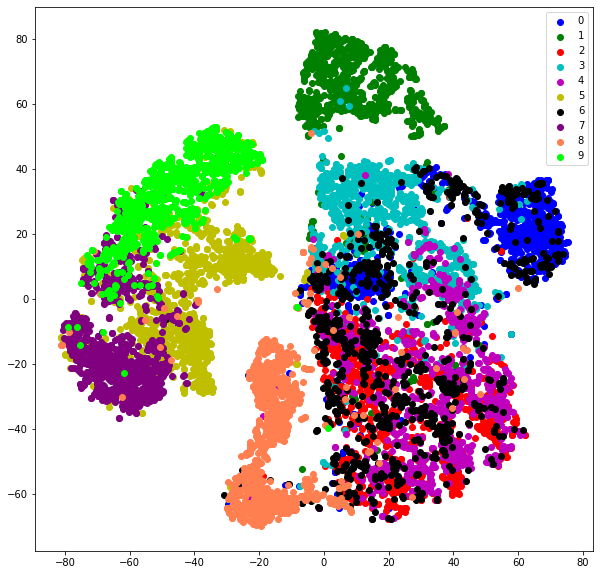

In [39]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_test) 
colors_map = np.argmax(y_test, axis=1)
nb_classes = 10
colors = np.array([x for x in 'b-g-r-c-m-y-k-purple-coral-lime'.split('-')])
colors_map = colors_map
plt.figure(figsize=(10,10))
for cl in range(nb_classes):
    indices = np.where(colors_map==cl)
    plt.scatter(X_tsne[indices,0], X_tsne[indices, 1], c=colors[cl], label=cl)
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


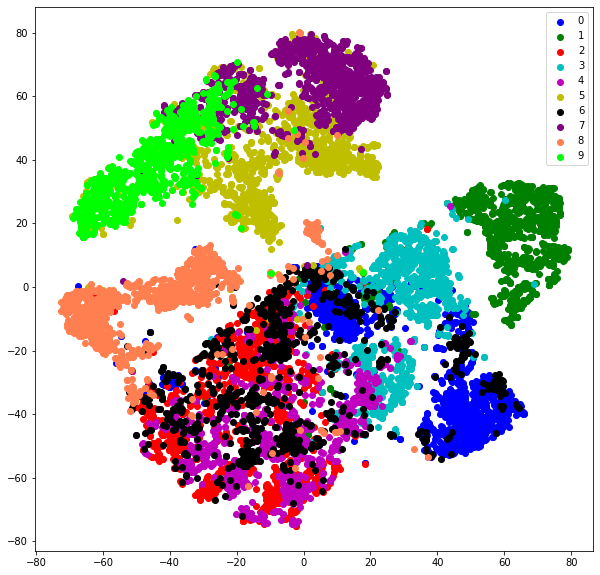

In [43]:
preds = mlp_on_cpu.forward(X_test)
preds = tf.nn.softmax(preds)
tsne = TSNE(n_components=2)
#final_pre
X_tsne = tsne.fit_transform(X_test) 
#X_tsne = np.argmax(preds, axis=1) 
colors_map = np.argmax(preds, axis=1)
X_tsne.shape
nb_classes = 10
colors = np.array([x for x in 'b-g-r-c-m-y-k-purple-coral-lime'.split('-')])
colors_map = colors_map
plt.figure(figsize=(10,10))
for cl in range(nb_classes):
    indices = np.where(colors_map==cl)
    plt.scatter(X_tsne[indices,0], X_tsne[indices, 1], c=colors[cl], label=cl)
plt.legend()
plt.show()

In [35]:
time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(X_test)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 43.132574796676636 seconds


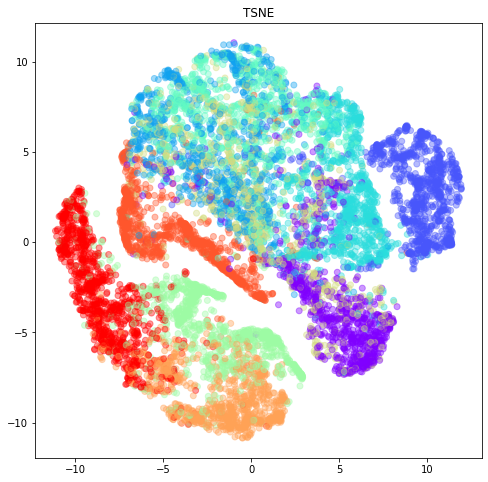

In [37]:
c_values = tf.argmax(y_test, axis=1)
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c = c_values,
    cmap=plt.cm.get_cmap('rainbow'), 
    alpha=0.4)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 29.67089295387268 seconds


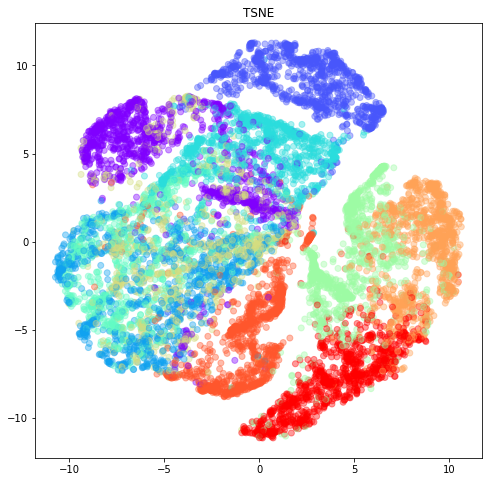

In [42]:
## Now for Model prediction
time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(X_test)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

preds = mlp_on_cpu.forward(X_test)
preds = tf.nn.softmax(preds)
c_values = tf.argmax(preds, axis=1)
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c = c_values,
    cmap=plt.cm.get_cmap('rainbow'), 
    alpha=0.4)
plt.show()